# The Packages

In [1]:
import numpy as np
import pandas as pd
import os
import gc
import datetime
import warnings

In [2]:

import statsmodels.api as sm
from datetime import date

In [3]:
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error

In [4]:
import tensorflow as tf
import math 
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers import LSTM
from tensorflow.keras import losses
from tensorflow import keras
from tensorflow.keras.callbacks import ModelCheckpoint, CSVLogger, ReduceLROnPlateau, EarlyStopping, TensorBoard
from tensorflow.keras.utils import plot_model

In [5]:
tf.__version__

'2.10.1'

In [6]:
# DATA VISUALIZATION
# ------------------------------------------------------
import matplotlib.pyplot as plt
import seaborn as sns
plt.rcParams['figure.figsize'] = (20.0, 10.0)
sns.set_style("darkgrid")
sns.color_palette("mako", as_cmap=True)
import plotly.express as px


In [7]:
# CONFIGURATIONS
# ------------------------------------------------------
pd.set_option('display.max_columns', None)
pd.options.display.float_format = '{:.2f}'.format
warnings.filterwarnings('ignore')

In [8]:
tf.random.set_seed(99)
np.random.seed(99)

# Utility Functions

In [9]:
def plotSeries(time, series, lab,form='-'):
    plt.plot(time, series, form, label=lab)
    plt.xlabel("Date")
    plt.ylabel("Close Price")
    plt.grid(True)

# The Data

In [10]:
wfc = pd.read_csv('Dataset/WFC Daily1.csv')

In [11]:
wfc.head()

,Date,Open,High,Low,Close,Adj Close,Volume
0,2000-01-03,20.16,20.19,19.00,19.56,10.44,9037000
1,2000-01-04,18.62,18.84,18.00,18.59,9.92,15237200
2,2000-01-05,18.50,18.88,18.03,18.41,9.82,8228200
3,2000-01-06,18.53,19.50,18.47,19.22,10.25,8326800
4,2000-01-07,19.62,19.84,19.28,19.56,10.44,7711200


In [12]:
wfc.Date.dtype

dtype('O')

In [13]:
wfc['Date'] = pd.to_datetime(wfc['Date'])
#wfc.set_index(['Date'],inplace=True)

In [14]:
wfc.head()

,Date,Open,High,Low,Close,Adj Close,Volume
0,2000-01-03,20.16,20.19,19.00,19.56,10.44,9037000
1,2000-01-04,18.62,18.84,18.00,18.59,9.92,15237200
2,2000-01-05,18.50,18.88,18.03,18.41,9.82,8228200
3,2000-01-06,18.53,19.50,18.47,19.22,10.25,8326800
4,2000-01-07,19.62,19.84,19.28,19.56,10.44,7711200


In [15]:
wfc.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5754 entries, 0 to 5753
Data columns (total 7 columns):
 #   Column     Non-Null Count  Dtype         
---  ------     --------------  -----         
 0   Date       5754 non-null   datetime64[ns]
 1   Open       5754 non-null   float64       
 2   High       5754 non-null   float64       
 3   Low        5754 non-null   float64       
 4   Close      5754 non-null   float64       
 5   Adj Close  5754 non-null   float64       
 6   Volume     5754 non-null   int64         
dtypes: datetime64[ns](1), float64(5), int64(1)
memory usage: 314.8 KB


In [16]:
wfc.describe()

,Open,High,Low,Close,Adj Close,Volume
count,5754.00,5754.00,5754.00,5754.00,5754.00,5754.00
mean,36.38,36.78,35.98,36.38,28.01,24313450.19
std,11.74,11.77,11.73,11.75,12.85,26705062.78
min,8.65,8.94,7.80,8.12,5.76,1774000.00
25%,26.71,27.20,26.25,26.74,18.01,10091200.00
50%,32.65,33.13,32.25,32.64,23.18,17086600.00
75%,47.75,48.19,47.33,47.79,41.58,29145250.00
max,65.89,66.31,65.66,65.93,57.96,478736600.00


In [17]:
correlation = wfc.corr ()  
correlation. style.background_gradient ()

,Open,High,Low,Close,Adj Close,Volume
Open,1.000000,0.999324,0.999274,0.998754,0.965403,-0.184389
High,0.999324,1.000000,0.998796,0.999323,0.967945,-0.169457
Low,0.999274,0.998796,1.000000,0.999303,0.963519,-0.199335
Close,0.998754,0.999323,0.999303,1.000000,0.966149,-0.183272
Adj Close,0.965403,0.967945,0.963519,0.966149,1.000000,-0.080189
Volume,-0.184389,-0.169457,-0.199335,-0.183272,-0.080189,1.000000


# The Split

In [18]:
min_date = wfc.Date.min()
max_date = wfc.Date.max()
print("Min:", min_date, "Max:", max_date)

Min: 2000-01-03 00:00:00 Max: 2022-11-11 00:00:00


In [19]:
train_percent = .75
valid_percent = .12

time_between = max_date - min_date

train_cutoff = min_date + train_percent*time_between
valid_cutoff = min_date + (train_percent + valid_percent)*time_between

print("Training Cutoff Date: {:s}".format(str(train_cutoff)))
print("Validation Cutoff Date: {:s}".format(str(valid_cutoff)))

Training Cutoff Date: 2017-02-23 00:00:00
Validation Cutoff Date: 2019-11-21 18:14:24


In [20]:
train_df = wfc[wfc.Date <= train_cutoff]
valid_df = wfc[(wfc.Date > train_cutoff) & (wfc.Date <= valid_cutoff)]
test_df = wfc[wfc.Date > valid_cutoff]


In [21]:
print("Dataset shape: {:s}".format(str(wfc.shape)))
print("Train dataset shape: {:s}".format(str(train_df.shape)))
print("Vaid dataset shape: {:s}".format(str(valid_df.shape)))
print("Test dataset shape: {:s}".format(str(test_df.shape)))

Dataset shape: (5754, 7)
Train dataset shape: (4313, 7)
Vaid dataset shape: (692, 7)
Test dataset shape: (749, 7)


# Stock Price Graph

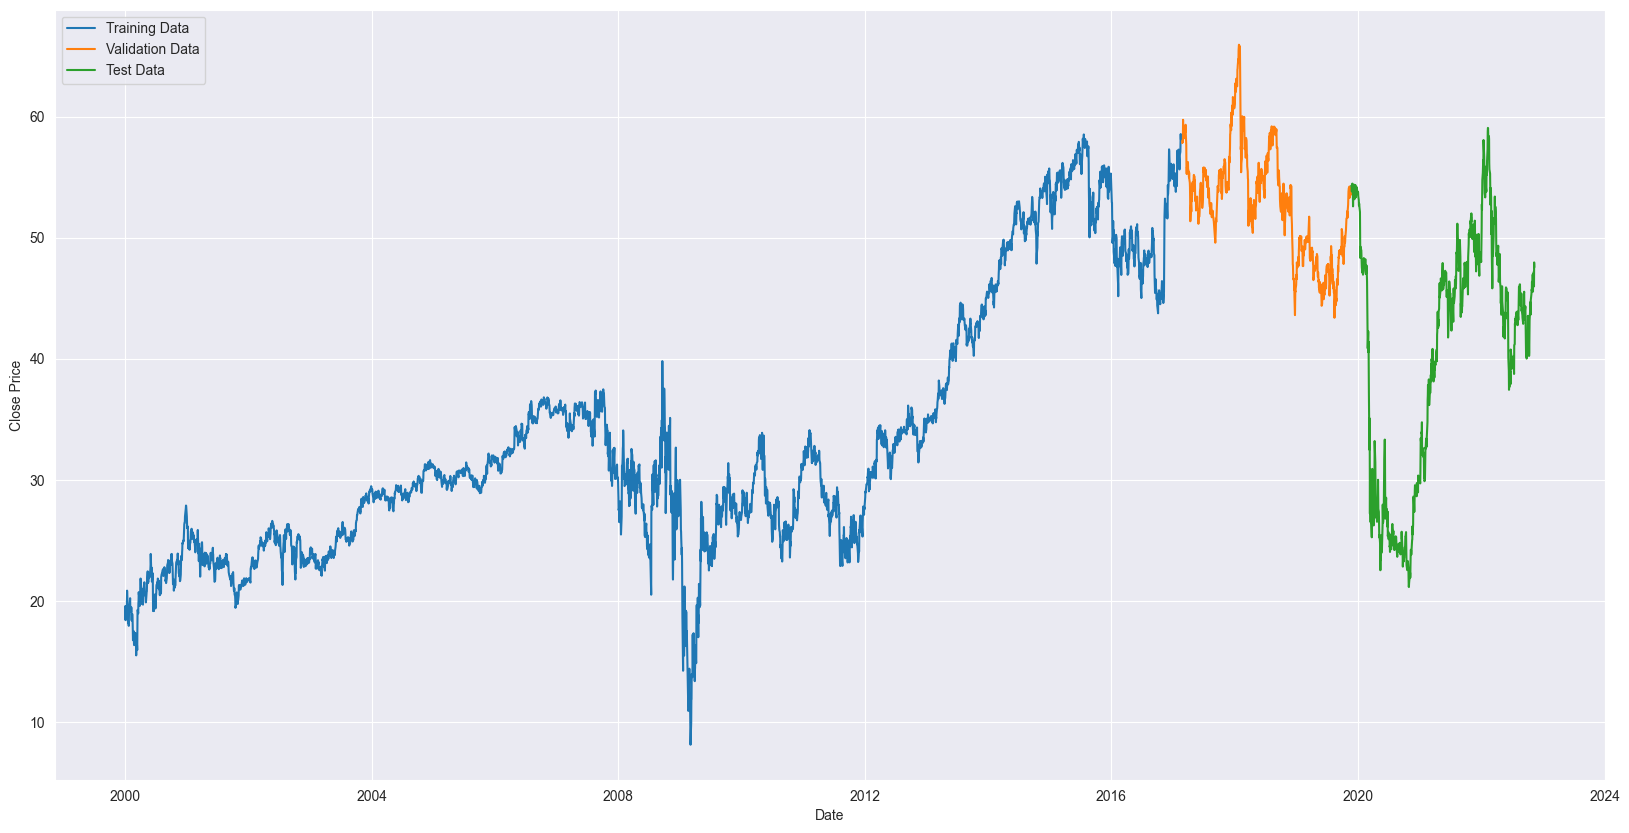

In [22]:
plotSeries(train_df.Date, train_df.Close, "Training Data")
plotSeries(valid_df.Date, valid_df.Close, "Validation Data")
plotSeries(test_df.Date, test_df.Close, "Test Data")
plt.legend(loc='upper left')

In [23]:
train_df.set_index(['Date'],inplace=True)
test_df.set_index(['Date'],inplace=True)
valid_df.set_index(['Date'],inplace=True)

In [24]:
trainNorm = train_df.Close.values.reshape(-1, 1)
testNorm = test_df.Close.values.reshape(-1, 1)
validNorm = valid_df.Close.values.reshape(-1, 1)

In [25]:
trainNorm.shape

(4313, 1)

## Windowed Dataset

In [26]:
mse_arr=[]
Z = []

window = 5

In [27]:
X_train= []
Y_train=[]
X_valid= []
Y_valid=[]
X_test= []
Y_test=[]

for i in range(len(trainNorm) - (window)):
    X_train.append(trainNorm[i:i+window])
    Y_train.append(trainNorm[i+window])
    
for i in range(len(validNorm) - (window)):
    X_valid.append(validNorm[i:i+window])
    Y_valid.append(validNorm[i+window])
    
for i in range(len(testNorm) - (window)):
    X_test.append(testNorm[i:i+window])
    Y_test.append(testNorm[i+window])
    

X_train=np.asanyarray(X_train)
Y_train=np.asanyarray(Y_train)
X_valid=np.asanyarray(X_valid)
Y_valid=np.asanyarray(Y_valid)
X_test=np.asanyarray(X_test)
Y_test=np.asanyarray(Y_test)

Xtrain = X_train[:,:,:]  
Ytrain = Y_train[:]  
Xvalid = X_valid[:,:,:]  
Yvalid= Y_valid[:]  
Xtest = X_test[:,:,:]  
Ytest= Y_test[:]  

# Model Building

In [28]:
tf.keras.backend.clear_session()
model = tf.keras.Sequential()

In [29]:
model.add(keras.layers.Conv1D(filters=16, kernel_size = 5,
                           strides=1, padding="causal",
                           activation="relu",
                           input_shape=[window, 1]),)
model.add(keras.layers.Conv1D(filters=32, kernel_size = 5,
                           strides=1, padding="causal",
                           activation="relu",
                           input_shape=[window, 1]),)
model.add(keras.layers.Bidirectional(tf.keras.layers.LSTM(32, return_sequences=True)))
model.add(keras.layers.Bidirectional(tf.keras.layers.LSTM(32)))

model.add(keras.layers.Dense(1))

## Final Model Build

In [30]:
tf.keras.backend.clear_session()

In [31]:
model.compile(loss=tf.keras.losses.MeanSquaredError(),
              optimizer=Adam(1e-3),
              metrics=['mae'])

In [32]:
log_dir = "logs\\" + datetime.datetime.now().strftime("%d-%m-%Y_%H%M%S")

tensorboard_callback = [
#                         tf.keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1),
#                         ModelCheckpoint(model_path, verbose=1, save_best_only=True),
#                         ReduceLROnPlateau(monitor= "val_mae", factor=0.1, patience=5, min_lr=1e-7, verbose=1),
                        ReduceLROnPlateau(monitor='val_mae', factor=0.3,patience=5, min_lr=1e-6, verbose=1),
#                         CSVLogger(csv_path),
                        TensorBoard(),
                        EarlyStopping(monitor= "val_mae", patience=10, restore_best_weights=True)
                       ]

In [33]:
history = model.fit(Xtrain, Ytrain,batch_size=128, epochs=500, verbose=1,validation_data=(Xvalid, Yvalid), callbacks=tensorboard_callback)

Epoch 1/500
34/34 [==============================] - 9s 58ms/step - loss: 954.0449 - mae: 29.0307 - val_loss: 1957.0664 - val_mae: 44.0139 - lr: 0.0010
Epoch 2/500
34/34 [==============================] - 0s 10ms/step - loss: 567.2959 - mae: 21.4818 - val_loss: 1540.6666 - val_mae: 38.9970 - lr: 0.0010
Epoch 3/500
34/34 [==============================] - 0s 9ms/step - loss: 430.3277 - mae: 18.0462 - val_loss: 1349.3701 - val_mae: 36.4617 - lr: 0.0010
Epoch 4/500
34/34 [==============================] - 0s 9ms/step - loss: 351.9357 - mae: 15.7674 - val_loss: 1197.5979 - val_mae: 34.3173 - lr: 0.0010
Epoch 5/500
34/34 [==============================] - 0s 9ms/step - loss: 292.3135 - mae: 13.8077 - val_loss: 1069.8141 - val_mae: 32.4021 - lr: 0.0010
Epoch 6/500
34/34 [==============================] - 0s 8ms/step - loss: 245.8317 - mae: 12.1139 - val_loss: 961.1904 - val_mae: 30.6801 - lr: 0.0010
Epoch 7/500
34/34 [==============================] - 0s 9ms/step - loss: 209.5550 - mae: 10.7

34/34 [==============================] - 0s 9ms/step - loss: 0.4901 - mae: 0.4543 - val_loss: 4.2816 - val_mae: 1.1350 - lr: 3.0000e-04
Epoch 112/500
34/34 [==============================] - 0s 10ms/step - loss: 0.4839 - mae: 0.4501 - val_loss: 4.2710 - val_mae: 1.1364 - lr: 3.0000e-04
Epoch 113/500
34/34 [==============================] - 0s 9ms/step - loss: 0.4865 - mae: 0.4536 - val_loss: 4.2423 - val_mae: 1.1302 - lr: 3.0000e-04
Epoch 114/500
34/34 [==============================] - 0s 9ms/step - loss: 0.4838 - mae: 0.4512 - val_loss: 4.2494 - val_mae: 1.1450 - lr: 3.0000e-04
Epoch 115/500
34/34 [==============================] - 0s 10ms/step - loss: 0.4761 - mae: 0.4437 - val_loss: 4.1991 - val_mae: 1.1203 - lr: 3.0000e-04
Epoch 116/500
34/34 [==============================] - 0s 9ms/step - loss: 0.4992 - mae: 0.4657 - val_loss: 4.2009 - val_mae: 1.1374 - lr: 3.0000e-04
Epoch 117/500
34/34 [==============================] - 0s 9ms/step - loss: 0.5087 - mae: 0.4732 - val_loss: 4.15

Epoch 165/500
32/34 [===========================>..] - ETA: 0s - loss: 0.4704 - mae: 0.4533
Epoch 165: ReduceLROnPlateau reducing learning rate to 2.700000040931627e-05.
34/34 [==============================] - 0s 9ms/step - loss: 0.4652 - mae: 0.4507 - val_loss: 3.6556 - val_mae: 1.0485 - lr: 9.0000e-05
Epoch 166/500
34/34 [==============================] - 0s 9ms/step - loss: 0.4476 - mae: 0.4334 - val_loss: 3.6752 - val_mae: 1.0645 - lr: 2.7000e-05
Epoch 167/500
34/34 [==============================] - 0s 8ms/step - loss: 0.4472 - mae: 0.4335 - val_loss: 3.6847 - val_mae: 1.0719 - lr: 2.7000e-05
Epoch 168/500
34/34 [==============================] - 0s 9ms/step - loss: 0.4504 - mae: 0.4354 - val_loss: 3.6391 - val_mae: 1.0420 - lr: 2.7000e-05
Epoch 169/500
34/34 [==============================] - 0s 9ms/step - loss: 0.4453 - mae: 0.4309 - val_loss: 3.6433 - val_mae: 1.0467 - lr: 2.7000e-05
Epoch 170/500
34/34 [==============================] - 0s 9ms/step - loss: 0.4426 - mae: 0.428

Epoch 271/500
34/34 [==============================] - 0s 9ms/step - loss: 0.4332 - mae: 0.4248 - val_loss: 3.4133 - val_mae: 1.0094 - lr: 2.4300e-06
Epoch 272/500
34/34 [==============================] - 0s 9ms/step - loss: 0.4335 - mae: 0.4249 - val_loss: 3.4128 - val_mae: 1.0099 - lr: 2.4300e-06
Epoch 273/500
34/34 [==============================] - 0s 9ms/step - loss: 0.4331 - mae: 0.4248 - val_loss: 3.4110 - val_mae: 1.0088 - lr: 2.4300e-06
Epoch 274/500
34/34 [==============================] - 0s 9ms/step - loss: 0.4332 - mae: 0.4248 - val_loss: 3.4106 - val_mae: 1.0095 - lr: 2.4300e-06
Epoch 275/500
34/34 [==============================] - 0s 9ms/step - loss: 0.4330 - mae: 0.4249 - val_loss: 3.4092 - val_mae: 1.0089 - lr: 2.4300e-06
Epoch 276/500
34/34 [==============================] - 0s 9ms/step - loss: 0.4332 - mae: 0.4252 - val_loss: 3.4085 - val_mae: 1.0093 - lr: 2.4300e-06
Epoch 277/500
34/34 [==============================] - 0s 9ms/step - loss: 0.4330 - mae: 0.4249 - va

Epoch 325/500
34/34 [==============================] - 0s 9ms/step - loss: 0.4316 - mae: 0.4242 - val_loss: 3.3652 - val_mae: 1.0022 - lr: 1.0000e-06
Epoch 326/500
34/34 [==============================] - 0s 9ms/step - loss: 0.4314 - mae: 0.4240 - val_loss: 3.3645 - val_mae: 1.0023 - lr: 1.0000e-06
Epoch 327/500
34/34 [==============================] - 0s 9ms/step - loss: 0.4314 - mae: 0.4241 - val_loss: 3.3639 - val_mae: 1.0023 - lr: 1.0000e-06
Epoch 328/500
34/34 [==============================] - 0s 9ms/step - loss: 0.4312 - mae: 0.4239 - val_loss: 3.3633 - val_mae: 1.0020 - lr: 1.0000e-06
Epoch 329/500
34/34 [==============================] - 0s 9ms/step - loss: 0.4313 - mae: 0.4241 - val_loss: 3.3628 - val_mae: 1.0022 - lr: 1.0000e-06
Epoch 330/500
34/34 [==============================] - 0s 8ms/step - loss: 0.4312 - mae: 0.4241 - val_loss: 3.3621 - val_mae: 1.0023 - lr: 1.0000e-06
Epoch 331/500
34/34 [==============================] - 0s 9ms/step - loss: 0.4312 - mae: 0.4241 - va

Epoch 380/500
34/34 [==============================] - 0s 9ms/step - loss: 0.4301 - mae: 0.4236 - val_loss: 3.3282 - val_mae: 0.9977 - lr: 1.0000e-06
Epoch 381/500
34/34 [==============================] - 0s 9ms/step - loss: 0.4302 - mae: 0.4237 - val_loss: 3.3274 - val_mae: 0.9973 - lr: 1.0000e-06
Epoch 382/500
34/34 [==============================] - 0s 11ms/step - loss: 0.4301 - mae: 0.4236 - val_loss: 3.3266 - val_mae: 0.9970 - lr: 1.0000e-06
Epoch 383/500
34/34 [==============================] - 0s 9ms/step - loss: 0.4303 - mae: 0.4238 - val_loss: 3.3259 - val_mae: 0.9968 - lr: 1.0000e-06
Epoch 384/500
34/34 [==============================] - 0s 9ms/step - loss: 0.4301 - mae: 0.4236 - val_loss: 3.3251 - val_mae: 0.9967 - lr: 1.0000e-06
Epoch 385/500
34/34 [==============================] - 0s 9ms/step - loss: 0.4301 - mae: 0.4237 - val_loss: 3.3244 - val_mae: 0.9967 - lr: 1.0000e-06
Epoch 386/500
34/34 [==============================] - 0s 9ms/step - loss: 0.4300 - mae: 0.4236 - v

Epoch 435/500
34/34 [==============================] - 0s 9ms/step - loss: 0.4290 - mae: 0.4232 - val_loss: 3.2891 - val_mae: 0.9919 - lr: 1.0000e-06
Epoch 436/500
34/34 [==============================] - 0s 9ms/step - loss: 0.4289 - mae: 0.4232 - val_loss: 3.2886 - val_mae: 0.9921 - lr: 1.0000e-06
Epoch 437/500
34/34 [==============================] - 0s 9ms/step - loss: 0.4289 - mae: 0.4232 - val_loss: 3.2876 - val_mae: 0.9917 - lr: 1.0000e-06
Epoch 438/500
34/34 [==============================] - 0s 9ms/step - loss: 0.4289 - mae: 0.4231 - val_loss: 3.2870 - val_mae: 0.9915 - lr: 1.0000e-06
Epoch 439/500
34/34 [==============================] - 0s 9ms/step - loss: 0.4289 - mae: 0.4233 - val_loss: 3.2865 - val_mae: 0.9920 - lr: 1.0000e-06
Epoch 440/500
34/34 [==============================] - 0s 8ms/step - loss: 0.4289 - mae: 0.4233 - val_loss: 3.2855 - val_mae: 0.9911 - lr: 1.0000e-06
Epoch 441/500
34/34 [==============================] - 0s 8ms/step - loss: 0.4289 - mae: 0.4233 - va

Epoch 490/500
34/34 [==============================] - 0s 9ms/step - loss: 0.4278 - mae: 0.4228 - val_loss: 3.2515 - val_mae: 0.9867 - lr: 1.0000e-06
Epoch 491/500
34/34 [==============================] - 0s 9ms/step - loss: 0.4278 - mae: 0.4228 - val_loss: 3.2508 - val_mae: 0.9864 - lr: 1.0000e-06
Epoch 492/500
34/34 [==============================] - 0s 9ms/step - loss: 0.4281 - mae: 0.4231 - val_loss: 3.2511 - val_mae: 0.9863 - lr: 1.0000e-06
Epoch 493/500
34/34 [==============================] - 0s 9ms/step - loss: 0.4281 - mae: 0.4230 - val_loss: 3.2494 - val_mae: 0.9861 - lr: 1.0000e-06
Epoch 494/500
34/34 [==============================] - 0s 9ms/step - loss: 0.4278 - mae: 0.4227 - val_loss: 3.2488 - val_mae: 0.9862 - lr: 1.0000e-06
Epoch 495/500
34/34 [==============================] - 0s 9ms/step - loss: 0.4278 - mae: 0.4230 - val_loss: 3.2482 - val_mae: 0.9865 - lr: 1.0000e-06
Epoch 496/500
34/34 [==============================] - 0s 10ms/step - loss: 0.4277 - mae: 0.4228 - v

In [34]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, 5, 16)             96        
                                                                 
 conv1d_1 (Conv1D)           (None, 5, 32)             2592      
                                                                 
 bidirectional (Bidirectiona  (None, 5, 64)            16640     
 l)                                                              
                                                                 
 bidirectional_1 (Bidirectio  (None, 64)               24832     
 nal)                                                            
                                                                 
 dense (Dense)               (None, 1)                 65        
                                                                 
Total params: 44,225
Trainable params: 44,225
Non-traina

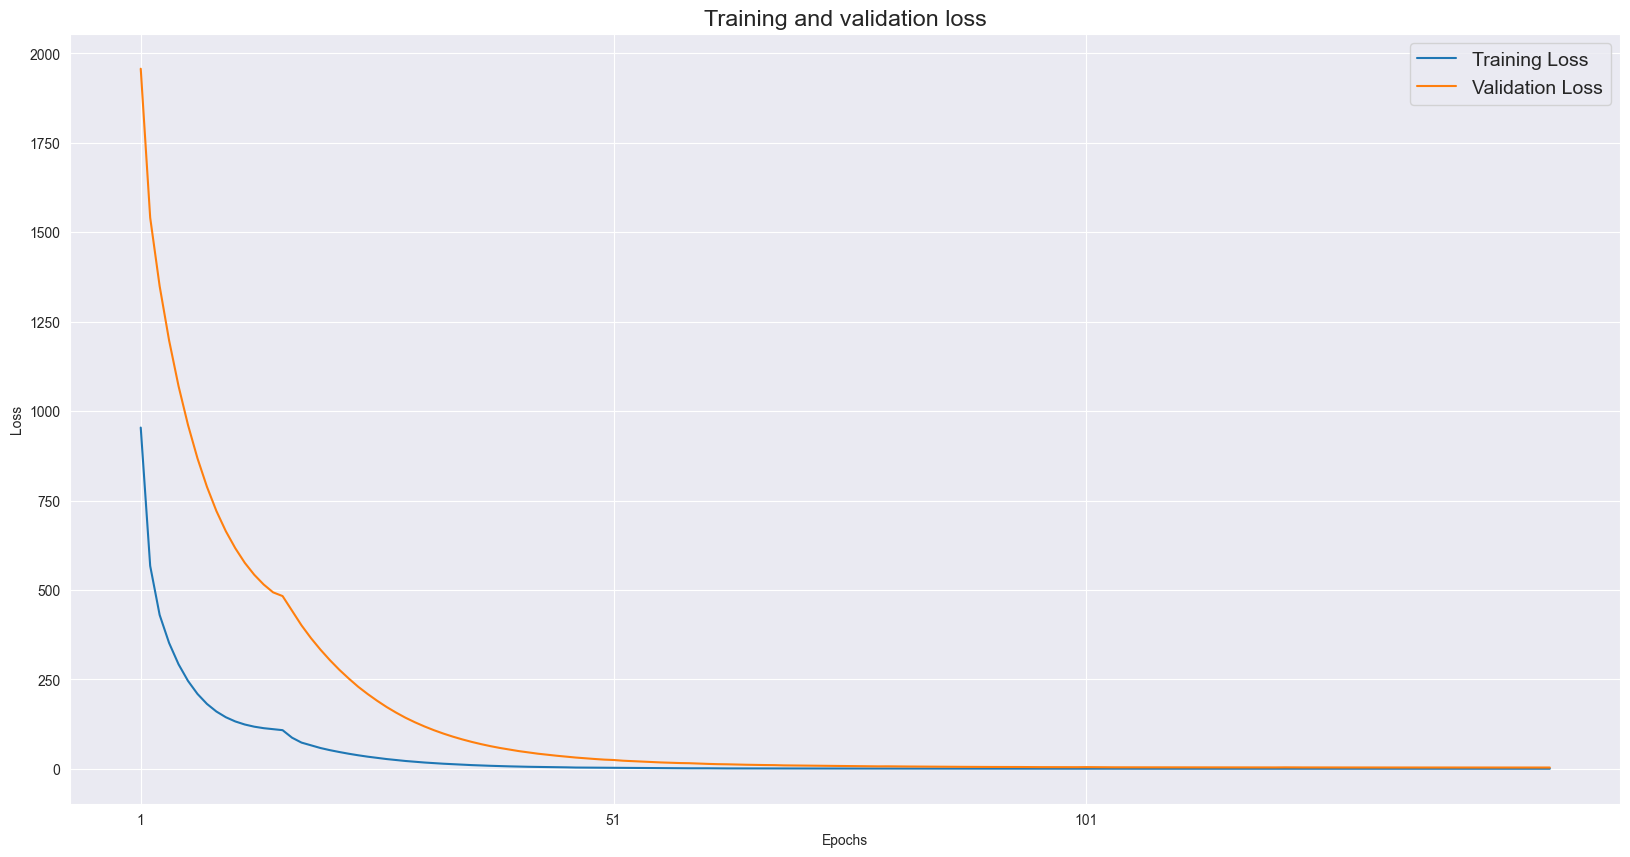

In [35]:
#Showing training and validation loss
history_dict = history.history
loss_values = history_dict['loss']
val_loss_values = history_dict['val_loss']
loss_values50 = loss_values[0:150]
val_loss_values50 = val_loss_values[0:150]
epochs = range(1, len(loss_values50) + 1)
plt.plot(epochs, loss_values50, label='Training Loss')
plt.plot(epochs, val_loss_values50, label='Validation Loss')
plt.rc('font', size = 14)
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.xticks(epochs)
plt.xticks(np.arange(min(epochs), max(epochs)+1, 50.0))
#fig.savefig('test&validationlosscnn.png', dpi=300)
plt.show()

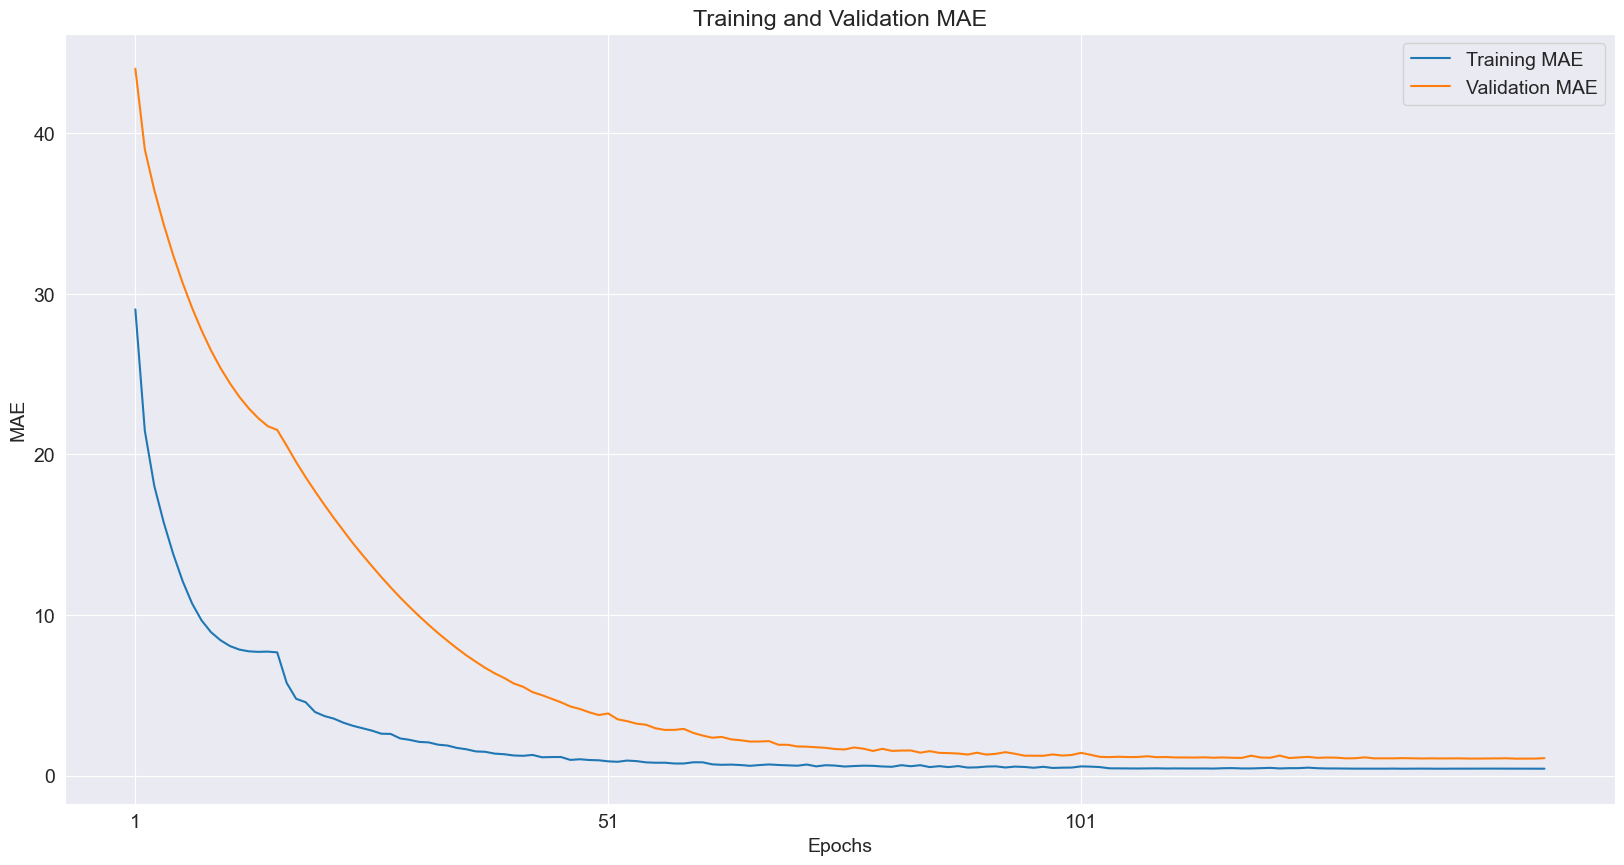

In [36]:
loss_values = history_dict['mae']
val_loss_values = history_dict['val_mae']
loss_values50 = loss_values[0:150]
val_loss_values50 = val_loss_values[0:150]
epochs = range(1, len(loss_values50) + 1)
plt.plot(epochs, loss_values50, label='Training MAE')
plt.plot(epochs, val_loss_values50, label='Validation MAE')
plt.rc('font', size = 14)
plt.title('Training and Validation MAE')
plt.xlabel('Epochs')
plt.ylabel('MAE')
plt.legend()
plt.xticks(epochs)
plt.xticks(np.arange(min(epochs), max(epochs)+1, 50.0))
#fig.savefig('test&validationlosscnn.png', dpi=300)
plt.show()

In [37]:
#Evaluating model
trainScore = model.evaluate(Xtrain, Ytrain, verbose=1)
validScore = model.evaluate(Xvalid, Yvalid, verbose=1)
testScore = model.evaluate(Xtest, Ytest, verbose=1)

24/24 [==============================] - 0s 2ms/step - loss: 1.0874 - mae: 0.7564


In [38]:
testScore, validScore, trainScore

([1.0874403715133667, 0.7563628554344177],
 [3.24465274810791, 0.985518217086792],
 [0.42740628123283386, 0.42261365056037903])

In [39]:
preds = model.predict(Xtest)

24/24 [==============================] - 1s 2ms/step


In [40]:
Xtest.shape

(744, 5, 1)

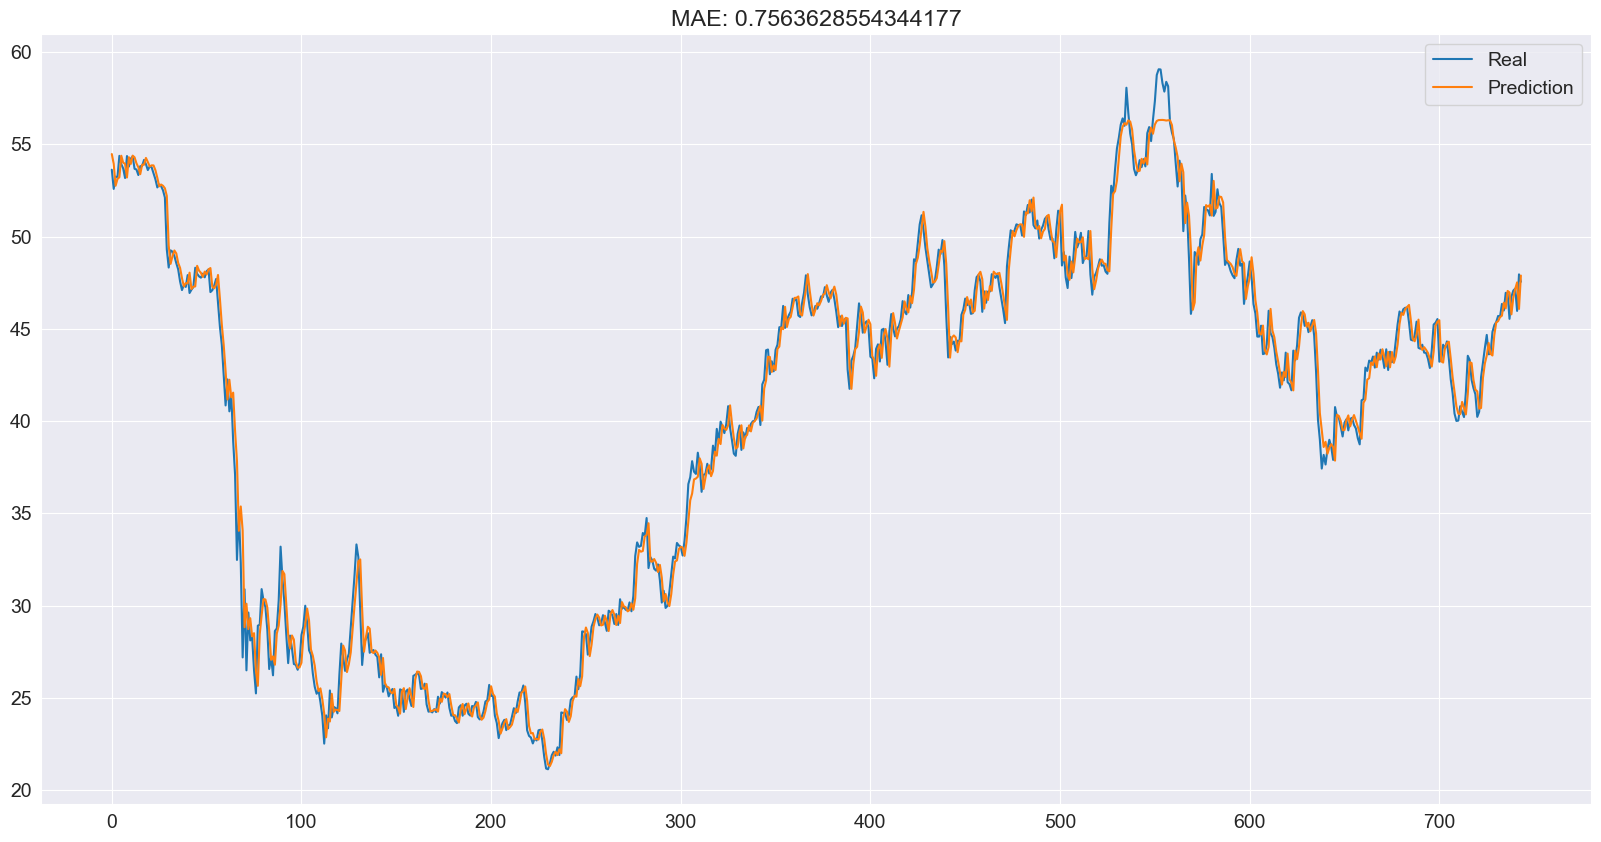

In [41]:
plt.title('MAE: {}'.format(testScore[1]))
plt.plot(Ytest, label='Real')
plt.plot(preds, label='Prediction')

plt.legend(loc="best")

#for saving figures
# plt.savefig('CPALL_graph.png')
plt.show()

In [42]:
#denormalizing datasets
# preds = scaler.inverse_transform(preds)
# Ytest = scaler.inverse_transform(Ytest)

In [43]:
#Show Train and Test Scores
print('Train MSE \t Train RMSE \t Train MAE \t Testscore RMSE \tTest MSE \tTest MAE')
print('%.9f \t %.9f \t %.9f \t %.9f \t \t %.9f \t %.9f' % (trainScore[0], math.sqrt(trainScore[0]),trainScore[1],math.sqrt(testScore[0]),testScore[0],testScore[1]))

Train MSE 	 Train RMSE 	 Train MAE 	 Testscore RMSE 	Test MSE 	Test MAE
0.427406281 	 0.653763169 	 0.422613651 	 1.042804091 	 	 1.087440372 	 0.756362855


In [44]:
print('MAE \t\t MAPE')
print('%.4f \t\t %.4f' % (mean_absolute_error(Ytest,preds),(np.mean(np.abs((Ytest - preds) / Ytest)) * 100)))

MAE 		 MAPE
0.7564 		 1.9965
